In [0]:
import numpy as np 
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import FreqDist
import string
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize, FreqDist
from sklearn.metrics.classification import accuracy_score, log_loss
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [0]:
from google.colab import files
uploaded = files.upload()


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c msk-redefining-cancer-treatment

In [0]:
!unzip training_variants.zip
!unzip test_variants.zip
!unzip training_text.zip
!unzip test_text.zip

In [0]:
df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


ID      0
Text    5
dtype: int64

In [0]:
df_train_txt.dropna(axis=0,how='any', inplace=True)
df_train_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [0]:
df_train_var = pd.read_csv('training_variants')
df_train_var.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [0]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [0]:
df_train["Text"]=df_train["Text"]+" "+df_train["Gene"]+" "+df_train["Variation"]
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [0]:
stop = stopwords.words('english')+["mutat","cell","cancer","fig","mutant"]
snowball = nltk.SnowballStemmer('english')
WNlemma = nltk.WordNetLemmatizer()
def preprocess(toks):
    toks = [ t.lower() for t in toks if t not in string.punctuation ]
    toks = [t for t in toks if t not in stop ]
    toks = [ snowball.stem(t) for t in toks ]
    toks = [ WNlemma.lemmatize(t) for t in toks ]
    toks = [t for t in toks if t not in stop ]
    #toks_clean = [ t for t in toks if len(t) >= 3 ]
    return toks

In [0]:
df_train['Text']=df_train['Text'].apply(lambda x: str(x))
df_train['Tokens'] = df_train['Text'].apply(lambda x: word_tokenize(x))
df_train['Tokens_clean'] = df_train['Tokens'].apply(lambda x: preprocess(x))
df_train['Clean_text'] = df_train['Tokens_clean'].apply(lambda x: ' '.join(x))
df_train['Length']=df_train['Tokens_clean'].apply(lambda x: len(x))

In [0]:
df_train.head()

,ID,Gene,Variation,Class,Text,Tokens,Tokens_clean,Clean_text,Length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,"[Cyclin-dependent, kinases, (, CDKs, ), regula...","[cyclin-depend, kina, cdks, regul, varieti, fu...",cyclin-depend kina cdks regul varieti fundamen...,3868
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","[abstract, background, non-smal, lung, nsclc, ...",abstract background non-smal lung nsclc hetero...,3489
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,"[Abstract, Background, Non-small, cell, lung, ...","[abstract, background, non-smal, lung, nsclc, ...",abstract background non-smal lung nsclc hetero...,3489
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,"[Recent, evidence, has, demonstrated, that, ac...","[recent, evid, demonstr, acquir, uniparent, di...",recent evid demonstr acquir uniparent disomi a...,3514
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,"[Oncogenic, mutations, in, the, monomeric, Cas...","[oncogen, monomer, casita, b-lineag, lymphoma,...",oncogen monomer casita b-lineag lymphoma cbl g...,3698


In [0]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['Clean_text'].values)

In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 162825 unique tokens.


In [0]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train['Clean_text'].values)
X = pad_sequences(X, maxlen=2000)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3321, 2000)


In [0]:
# Build simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from sklearn.model_selection import train_test_split
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2656, 2000) (2656, 9)
(665, 2000) (665, 9)


In [0]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs=6, batch_size=batch_size, validation_split=0.2, 
                    callbacks=[ckpt_callback])

Instructions for updating:
Use tf.cast instead.
Train on 2124 samples, validate on 532 samples
Epoch 1/6
2124/2124 [==============================] - 466s 219ms/step - loss: 1.8139 - categorical_crossentropy: 1.8139 - val_loss: 1.5245 - val_categorical_crossentropy: 1.5245

Epoch 00001: val_loss improved from inf to 1.52450, saving model to keras_model
Epoch 2/6
2124/2124 [==============================] - 463s 218ms/step - loss: 1.2678 - categorical_crossentropy: 1.2678 - val_loss: 1.1681 - val_categorical_crossentropy: 1.1681

Epoch 00002: val_loss improved from 1.52450 to 1.16814, saving model to keras_model
Epoch 3/6
2124/2124 [==============================] - 463s 218ms/step - loss: 0.9774 - categorical_crossentropy: 0.9774 - val_loss: 1.0593 - val_categorical_crossentropy: 1.0593

Epoch 00003: val_loss improved from 1.16814 to 1.05928, saving model to keras_model
Epoch 4/6
2124/2124 [==============================] - 465s 219ms/step - loss: 0.8262 - categorical_crossentropy: 0.8

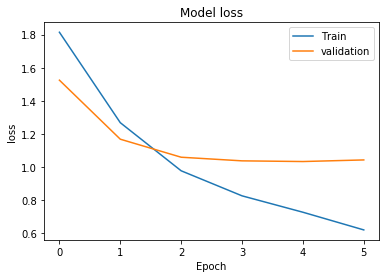

In [0]:
# Plot training & validation loss values
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='best')
plt.show()

In [0]:
model = load_model('keras_model')

In [0]:
probas = model.predict(X_test)

In [0]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))

Log loss: 1.1267439409502242
Accuracy: 0.6300751879699248


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix


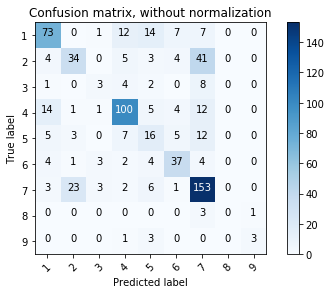

<Figure size 432x288 with 0 Axes>

In [0]:
from sklearn import metrics 
import itertools
# print(metrics.classification_report(Y_test, probas))
cnf_matrix= metrics.confusion_matrix(Y_test.argmax(axis=1), probas.argmax(axis=1))
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(1,10)],
                      title='Confusion matrix, without normalization')
plt.figure()
plt.show()